# Objective - Prepare solution to build ticketing system 



In [1]:
import pandas as pd
import json
import numpy as np
import re
import spacy,nltk
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.decomposition import NMF
import pickle

# Loading the data

In [2]:
with open('Client_data.json') as f:  
      data = json.load(f)
df=pd.json_normalize(data)

df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


# Data prepration and Exploratory Data Analysis

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [4]:
df.describe

<bound method NDFrame.describe of                     _index      _type      _id  _score   _source.tags  \
0      complaint-public-v2  complaint  3211475     0.0           None   
1      complaint-public-v2  complaint  3229299     0.0  Servicemember   
2      complaint-public-v2  complaint  3199379     0.0           None   
3      complaint-public-v2  complaint  2673060     0.0           None   
4      complaint-public-v2  complaint  3203545     0.0           None   
...                    ...        ...      ...     ...            ...   
78308  complaint-public-v2  complaint  3105617     0.0           None   
78309  complaint-public-v2  complaint  3091984     0.0           None   
78310  complaint-public-v2  complaint  3133355     0.0           None   
78311  complaint-public-v2  complaint  3110963     0.0           None   
78312  complaint-public-v2  complaint  2001189     0.0           None   

      _source.zip_code _source.complaint_id  \
0                90301              321147

In [5]:
df.shape

(78313, 22)

In [6]:
df.isnull().sum()

_index                                   0
_type                                    0
_id                                      0
_score                                   0
_source.tags                         67413
_source.zip_code                      6757
_source.complaint_id                     0
_source.issue                            0
_source.date_received                    0
_source.state                         1991
_source.consumer_disputed                0
_source.product                          0
_source.company_response                 0
_source.company                          0
_source.submitted_via                    0
_source.date_sent_to_company             0
_source.company_public_response      78309
_source.sub_product                  10571
_source.timely                           0
_source.complaint_what_happened          0
_source.sub_issue                    46297
_source.consumer_consent_provided     1008
dtype: int64

### Updating column names 

In [7]:
df.columns = ['index', 'type', 'id', 'score', 'tags', 'zip_code','complaint_id', 'issue', 'date_received',
       'state', 'consumer_disputed', 'product','company_response', 'company', 'submitted_via',
       'date_sent_to_company', 'company_public_response','sub_product', 'timely',
       'complaint_what_happened', 'sub_issue','consumer_consent_provided']

In [8]:
df[df['complaint_what_happened'] == ''].index

Int64Index([    0,     3,     4,     5,     6,     7,     8,     9,    12,
               13,
            ...
            78292, 78298, 78299, 78300, 78302, 78304, 78305, 78306, 78307,
            78308],
           dtype='int64', length=57241)

### Replacing blank spaces with NaN 

In [9]:
df[df.loc[:, 'complaint_what_happened'] == ''] = np.nan

### Removing the rows which contains null values

In [10]:
df = df[df['complaint_what_happened'].notna()]

In [11]:
df.shape

(21072, 22)

In [12]:
df['complaint_what_happened'] = df['complaint_what_happened'].astype(str)

C:\Users\shubham_soni3\AppData\Local\Temp\ipykernel_21892\1429438214.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['complaint_what_happened'] = df['complaint_what_happened'].astype(str)


### Function for data cleaning

In [13]:
def clean_text(sent):
    sent = sent.lower() # Text to lowercase
    pattern = '[^\w\s]' # Removing punctuation
    sent = re.sub(pattern, '', sent) 
    pattern = '\w*\d\w*'
    sent = re.sub(pattern, '', sent) 
    return sent

In [14]:
cdf = pd.DataFrame(df['complaint_what_happened'].apply(clean_text))

In [15]:
cdf

,complaint_what_happened
1,good morning my name is xxxx xxxx and i apprec...
2,i upgraded my xxxx xxxx card in and was told ...
10,chase card was reported on however fraudulent...
11,on while trying to book a xxxx xxxx ticket ...
14,my grand son give me check for i deposit it i...
...,...
78303,after being a chase card customer for well ove...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...
78310,i am not familiar with xxxx pay and did not un...
78311,i have had flawless credit for yrs ive had ch...


In [16]:
#nlp = spacy.load("en_core_web_sm")

nlp = spacy.load('en_core_web_sm') 

### Function for Lemmitization

In [17]:
def lemmmatizing_text(text):
    sent = []
    doc = nlp(text)
    for token in doc:
        sent.append(token.lemma_)
    return " ".join(sent)

In [18]:
#cdf = cdf.sample(2000)

In [19]:
cdf['complaint_lemmatized'] = cdf['complaint_what_happened'].apply(lemmmatizing_text)

In [20]:
cdf

,complaint_what_happened,complaint_lemmatized
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...
...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx I call chas my xxxx xxxx...
78310,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...
78311,i have had flawless credit for yrs ive had ch...,I have have flawless credit for yr I ve have...


### Function for removing POS tags

In [21]:
def Pos_tags(text):
    sent = []
    blob = TextBlob(text)
    sent = [word for (word,tag) in blob.tags if tag=='NN']
    return " ".join(sent)

In [22]:
cdf['complaint_POS_removed'] = cdf['complaint_lemmatized'].apply(Pos_tags)

In [23]:
cdf

,complaint_what_happened,complaint_lemmatized,complaint_POS_removed
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent upgrade date agent information orde...
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book xxxx ticket offer ticket card informa...
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund bank account pay money ...
...,...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...,card customer decade solicitation credit card ...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx I call chas my xxxx xxxx...,visa credit card provider claim purchase prote...
78310,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...,pay risk provide consumer bank app chase year ...
78311,i have had flawless credit for yrs ive had ch...,I have have flawless credit for yr I ve have...,credit yr credit card chase freedom xxxx probl...


### Removing all the xxxx.... strings from the row

In [24]:
cdf['Complaint_clean'] = cdf['complaint_POS_removed'].str.replace('xxxx','') #removing xxxxx 

# Feature Extraction

### Converting data into TF-IDF feature matrix

In [25]:
tfidf = TfidfVectorizer(min_df=2, max_df=0.95, stop_words='english')

In [26]:
dm = tfidf.fit_transform(cdf['Complaint_clean'])

# Topic Modelling using NMF

In [27]:
num_topics = 5

nmf_model = NMF(n_components=num_topics, random_state=40)

In [28]:
nmf_model.fit(dm)
len(tfidf.get_feature_names())

C:\Users\shubham_soni3\Anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
C:\Users\shubham_soni3\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


7261

In [29]:
H = nmf_model.components_ 

### Printing top 10 words from each topic 

In [30]:
words = np.array(tfidf.get_feature_names())
topic_words = pd.DataFrame(np.zeros((num_topics, 10)), index=[f'Topic {i + 1}' for i in range(num_topics)],
                           columns=[f'Word {i + 1}' for i in range(10)]).astype(str)
for i in range(num_topics):
    ix = H[i].argsort()[::-1][:10]
    topic_words.iloc[i] = words[ix]

topic_words

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10
Topic 1,account,bank,check,money,fund,chase,deposit,branch,day,number
Topic 2,credit,card,report,inquiry,chase,account,score,company,limit,information
Topic 3,payment,balance,month,fee,statement,day,time,auto,date,pay
Topic 4,charge,card,fee,transaction,dispute,chase,merchant,fraud,purchase,claim
Topic 5,loan,mortgage,home,modification,chase,property,year,letter,rate,time


In [31]:
topic_results = nmf_model.transform(dm)

In [32]:
cdf['Topic'] = topic_results.argmax(axis=1)

In [33]:
cdf

,complaint_what_happened,complaint_lemmatized,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...,0
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...,1
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...,card report application identity consent servi...,1
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book xxxx ticket offer ticket card informa...,try book ticket offer ticket card information...,1
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...,0
...,...,...,...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...,card customer decade solicitation credit card ...,card customer decade solicitation credit card ...,1
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx I call chas my xxxx xxxx...,visa credit card provider claim purchase prote...,visa credit card provider claim purchase prote...,3
78310,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...,pay risk provide consumer bank app chase year ...,pay risk provide consumer bank app chase year ...,3
78311,i have had flawless credit for yrs ive had ch...,I have have flawless credit for yr I ve have...,credit yr credit card chase freedom xxxx probl...,credit yr credit card chase freedom problem b...,2


### Creating dictionary of category names 
 

In [34]:
Topic_names = {0:"Banking services", 1:"Card", 2:"Others",3:"Fraudalent reporting", 4:"Loans"}

cdf['Topic'] = cdf['Topic'].map(Topic_names)

In [35]:
cdf

,complaint_what_happened,complaint_lemmatized,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...,Banking services
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...,Card
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...,card report application identity consent servi...,Card
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book xxxx ticket offer ticket card informa...,try book ticket offer ticket card information...,Card
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...,Banking services
...,...,...,...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...,card customer decade solicitation credit card ...,card customer decade solicitation credit card ...,Card
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx I call chas my xxxx xxxx...,visa credit card provider claim purchase prote...,visa credit card provider claim purchase prote...,Fraudalent reporting
78310,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...,pay risk provide consumer bank app chase year ...,pay risk provide consumer bank app chase year ...,Fraudalent reporting
78311,i have had flawless credit for yrs ive had ch...,I have have flawless credit for yr I ve have...,credit yr credit card chase freedom xxxx probl...,credit yr credit card chase freedom problem b...,Others


### Creating data for model training 

In [36]:
training_data = cdf[['complaint_what_happened', 'Topic']]

In [37]:
training_data

,complaint_what_happened,Topic
1,good morning my name is xxxx xxxx and i apprec...,Banking services
2,i upgraded my xxxx xxxx card in and was told ...,Card
10,chase card was reported on however fraudulent...,Card
11,on while trying to book a xxxx xxxx ticket ...,Card
14,my grand son give me check for i deposit it i...,Banking services
...,...,...
78303,after being a chase card customer for well ove...,Card
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,Fraudalent reporting
78310,i am not familiar with xxxx pay and did not un...,Fraudalent reporting
78311,i have had flawless credit for yrs ive had ch...,Others


In [38]:
vect = CountVectorizer()
X_train_cnt = vect.fit_transform(training_data['complaint_what_happened'])

pickle.dump(vect.vocabulary_, open("count_vector.pk1", "wb"))

In [39]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_cnt)

pickle.dump(tfidf_transformer, open('tfidf.pk1', "wb"))

# Model Training

### Logistic Regression 

In [40]:
from sklearn.linear_model import LogisticRegression

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data['Topic'], test_size=0.3, random_state=42)

In [42]:
lg = LogisticRegression(random_state=42, solver='liblinear').fit(X_train, y_train)

#### Accuracy Score 

In [43]:
lg.score(X_test, y_test)

0.9172730148687124

In [44]:
pickle.dump(lg, open("lg_model.pk1", "wb"))

### Decision Tree  

In [45]:
from sklearn.tree import DecisionTreeClassifier

In [46]:
dt = DecisionTreeClassifier(random_state=42).fit(X_train, y_train)

#### Accuracy Score

In [47]:
dt.score(X_test, y_test)

0.7785510914267637

In [48]:
pickle.dump(dt, open("dt.pk1", "wb"))

### Random Forest

In [49]:
from sklearn.ensemble import RandomForestClassifier

In [50]:
rf = RandomForestClassifier(random_state=42).fit(X_train, y_train)

#### Accuracy Score

In [51]:
rf.score(X_test, y_test)

0.8101866497943688

In [52]:
pickle.dump(rf, open("rf.pk1", "wb"))

# Model Evaluation

### Evaluating  Logistic Regeression because its accuracy is higher than other models

#### Accuracy of Logistic Regerssion = 91.7%

In [53]:
pickle.dump(lg, open("lg.pk1", "wb"))
log_model = pickle.load(open("lg.pk1", "rb"))
y_pred = log_model.predict(X_test)

In [54]:
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score

## Confusion Matrix 

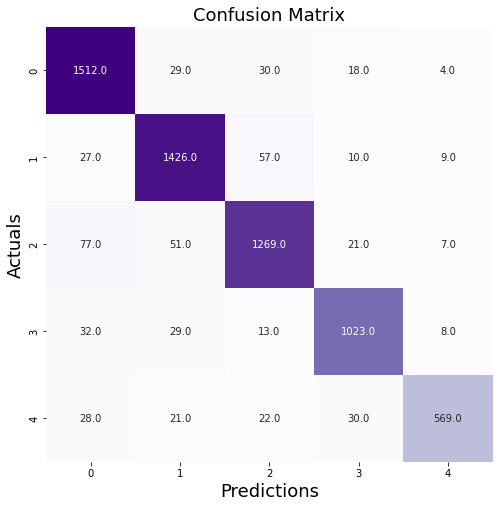

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8, 8))
ax = sns.heatmap(confusion_matrix(y_test, y_pred),
                 annot=True,
                 cbar=False,
                 cmap="Purples", fmt = '0.1f')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

# Classification Report

In [57]:
category_names = ["Banking services", "Loans", "Fraudalent reporting", "Card", "Others"]

In [58]:
print(classification_report(y_test, y_pred, target_names = category_names))

                      precision    recall  f1-score   support

    Banking services       0.90      0.95      0.93      1593
               Loans       0.92      0.93      0.92      1529
Fraudalent reporting       0.91      0.89      0.90      1425
                Card       0.93      0.93      0.93      1105
              Others       0.95      0.85      0.90       670

            accuracy                           0.92      6322
           macro avg       0.92      0.91      0.92      6322
        weighted avg       0.92      0.92      0.92      6322

